In [1]:
using PyPlot, Statistics, LinearAlgebra

# Mean and variance

Suppose we have a black box (a **distribution**) that generates data points $x_k$ (**samples**) $k = 1,2,\ldots$   If we have $m$ data points, the **sample mean µ** is simply the average:

$$
\mu = \frac{1}{m}\sum_{k=1}^m x_k
$$

In the limit $m \to \infty$, we get the mean of the underlying distribution from which the samples are generated.

The **sample variance S²** is the mean-square deviation from the mean:

$$
\operatorname{Var}(x) = S^2 = \frac{1}{m-1}\sum_{k=1}^m (x_k - \mu)^2
$$

where the denominator $m-1$ is [Bessel's correction](https://en.wikipedia.org/wiki/Bessel%27s_correction).  The limit $m\to\infty$ of the sample variance gives the variance of the underlying distribution, and by using $m-1$ instead of $m$ in the denominator it turns out that we get a better estimate of variance when $m$ is not huge.

For example, the `randn()` function in Julia draws samples from a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution): a Gaussian or "bell curve" with mean zero and variance 1:

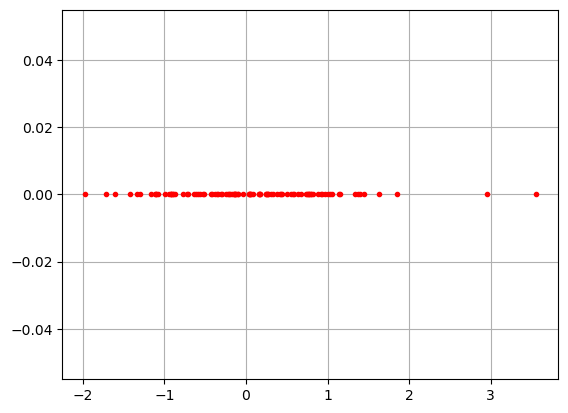

In [2]:
x = randn(100) # 100 gaussian random numbers:
plot(x, x * 0, "r.")
grid()

It is more informative to plot a [histogram](https://en.wikipedia.org/wiki/Histogram):

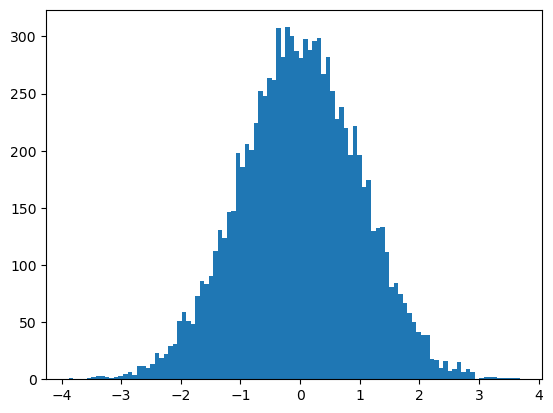

In [3]:
x = randn(10000)
hist(x, bins=100);

The mean is the **center** of this peak and the square root $S$ of the variance is a measure of the **width** of this peak.

The mean of those 10000 samples is a pretty good estimate for the true mean (= 0) of the underlying normal distribution:

In [4]:
mean(x)

-0.004847893500037312

The sample variance is:

In [5]:
sum((x.-mean(x)).^2)/(length(x)-1)

1.0092267528416228

Or (equivalently but more efficient) the function `var` from the [`Statistics` standard library](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) in Julia:

In [6]:
var(x)

1.0092267528416228

which is a pretty good estimate for the true variance (= 1).

If we looked at more points, we would get better estimates:

In [7]:
xbig = randn(10^7)
mean(xbig), var(xbig)

(0.0006185283563578413, 0.999645039441104)

## Mean and variance in linear algebra

If we define the vector $o = (1,1,\ldots)$ to be the vector of $m$ 1's, with $o^T o = m$, then the mean of $x$ is:

$$
\mu = \frac{o^T x}{o^T o}
$$

which is simply the coefficient in the **projection $o\frac{o^Tx}{o^To} = o\mu$ of x onto the line spanned by o**.   And the sample variance is

$$
\operatorname{Var}(x) = \frac{\Vert x - \mu o \Vert^2}{m-1} = \frac{\left\Vert \left(I - \frac{o o^T}{o^T o} \right) x \right\Vert^2}{m-1}
$$

is the **length² of the projection of x orthogonal to o** divided by $m-1$.

In fact, the $m-1$ denominator is closely related to the fact that this orthogonal projection has an $m-1$ dimensional column space (the complement of the line spanned by $o$): after you subtract off the mean, there are only $m-1$ degrees of freedom left.   (This is just a handwaving argument, but can be made precise; for more careful derivations of this denominator, see e.g. [Bessel's correction](https://en.wikipedia.org/wiki/Bessel%27s_correction) on Wikipedia or [this 18.06 notebook](http://nbviewer.jupyter.org/github/stevengj/1806/blob/spring18/lectures/Sample%20Variance%20division%20by%20n-1.ipynb).)

### Julia mean and variance by projection:

You can create a vector `o` of $$m$$ 1's in Julia simply via [`ones(m)`](https://docs.julialang.org/en/v1/base/arrays/#Base.ones), which means we could compute the mean and variance via:

In [8]:
o = ones(length(x))

10000-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

Mean $\mu = o^T x / o^T o$ via projection:

In [9]:
μ = o'x / o'o

-0.004847893500037312

In [10]:
mean(x) # same answer:

-0.004847893500037312

Variance via projection $\Vert (I - oo^T / o^T o) x\Vert^2 / (m-1)$:

In [11]:
norm((I - o*o'/o'o)*x)^2 / (o'o - 1)

1.0092267528416228

In [12]:
var(x) # same answer:

1.0092267528416228

One thing to be careful of whenever we perform projections is the parentheses: we could accidentally do a *lot* of unnecessary work!

In particular:

* Computing $(oo^T)x$ first forms an $m \times m$ matrix $oo^T$, and then multiples it by a vector $x$.  This requires $\Theta(m^2)$ arithmetic operations and storage for $m^2 numbers$ (the matrix).

* Computing $o(o^Tx)$ gives the same result, but only does a dot product $o^T x$ followed by a scalar–vector multiplication (scaling $o$), which requires $\Theta(m)$ arithmetic operations and storage for $m$ numbers (the vector).

Here, $m = 10^4$, so parenthesizing in the wrong way above means we took about 10000× more memory and time than we had to!   It's *much* more efficent to compute the projection via:
$$
\left(I - \frac{oo^T}{o^T o}\right) x = x - o\frac{o^T x}{o^T o}
$$
giving the variance as:

In [13]:
norm(x - o*(o'x)/o'o)^2 / (o'o - 1) # same answer, much faster

1.0092267528416228

# Covariance and Correlation

A key question in statistics is whether/how two sets of data are **correlated**.   If you have two variables $x$ and $y$, do they tend to "move together"?

An intuitive measure for this is: **when x is greater/less than its mean, is y *also* greater/less than its mean?**   Translated into math, this leads to the **covariance**:

$$
\operatorname{Covar}(x,y) = \frac{1}{m-1}\sum_{k=1}^m (x_k - \operatorname{mean}(x)) (y_k - \operatorname{mean}(y)) = \frac{(Px)^T (Py)}{m-1} = \frac{x^T P y}{m-1}
$$

where $P = I - \frac{oo^T}{o^T o}$ is the projection operator from above that subtracts the mean from a vector (i.e. it projects vectors onto the subspace of vectors with zero mean).  (In the last step we used the facts that $P^T = P$ and $P^2 = P$.)

For example, here are plots of two very correlated vectors x and y of data and a third data set z that is just independent random numbers

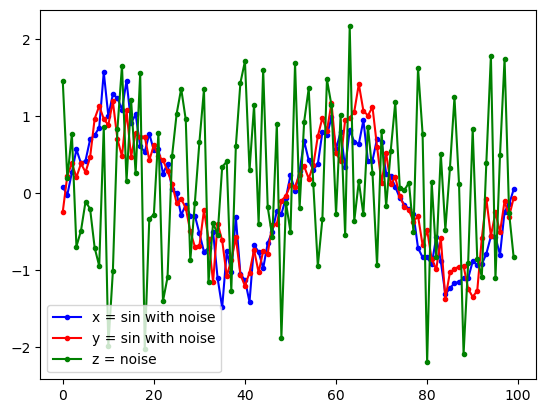

PyObject <matplotlib.legend.Legend object at 0x7f9f20e4f750>

In [14]:
θ = range(0,4π,length=100)
x = @. sin(θ + randn()*0.1) * (1 + 0.3*randn())
y = @. sin(θ + randn()*0.1) * (1 + 0.3*randn())
z = randn(100)
plot(x, "b.-")
plot(y, "r.-")
plot(z, "g.-")
legend(["x = sin with noise","y = sin with noise","z = noise"])

All three have mean nearly zero:

In [15]:
mean(x),mean(y),mean(z)

(-0.043997529467936246, -0.02138613818877366, 0.13625706217021702)

But the covariance of x and y is totally different from the covariance of x and z:

In [16]:
# A simple covariance function.  See https://github.com/JuliaStats/StatsBase.jl for
# better statistical functions in Julia.
covar(x,y) = dot(x .- mean(x), y .- mean(y)) / (length(x) - 1)

covar (generic function with 1 method)

In [17]:
covar(x,y), covar(x,z)

(0.49167750557613343, 0.022123022470670186)

The variance and covariance have the units of the data squared.  I can make the covariance of x and y smaller simply by dividing y by 10, which doesn't see like a good measure of how correlated they are.

Often, it is nicer to work with a dimensionless quantity *independent* of the vector lengths, the **correlation**:

$$
\operatorname{Cor}(x,y) = \frac{\operatorname{Covar}(x,y)}{\sqrt{\operatorname{Var}(x)  \operatorname{Var}(y)}} = \frac{(Px)^T (Py)}{\Vert Px \Vert \; \Vert Py \Vert}
$$

This is just the dot product of the vectors (after subtracting their means) divided by their lengths.

It turns out that Julia's Statistics module has a built-in function `cor` that computes precisely this:

In [18]:
covar(x,y) / sqrt(covar(x,x) * covar(y,y)) # correlation, manually computed

0.9083413856130808

In [19]:
cor(x,y)

0.9083413856130808

In [20]:
cor(x,z)

0.02974364653143366

In [21]:
abs(cor(x,y)/cor(x,z))

30.539005520157996

Now that we've scaled out the overall length of the vectors, we can sensibly compare the correlation of x,y with the correlation of x,z, and we see that the former are more than 10x the correlation of the latter in this sample

Another way of seeing this is to plot $y$ vs $x$ or $z$ vs $x$:

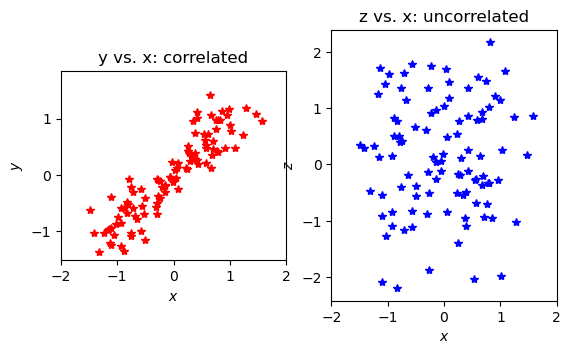

(-2.0, 2.0)

In [22]:
subplot(1,2,1)
plot(x, y, "r*")
axis("square")
title("y vs. x: correlated")
xlabel(L"x")
ylabel(L"y")
xlim(-2, 2)

subplot(1,2,2)
plot(x, z, "b*")
axis("square")
title("z vs. x: uncorrelated")
xlabel(L"x")
ylabel(L"z")
xlim(-2, 2)

# Multidimensional data

Instead of measuring *one* number per sample, we might be performing *many* measurements of $n$ different quantities, giving us an $m \times n$ *matrix* $X$ of "multidimensional" samples (one per row).

## Example: Fossil tooth data

A nice example was presented in [this AMS article](https://mathvoices.ams.org/featurecolumn/2021/08/01/principal-component-analysis/), taken in turn from [this review article](https://royalsocietypublishing.org/doi/10.1098/rsta.2015.0202).   Scientists had collected fossil teeth from species of an early mammal-like genus called [*Kuehneotherium*](https://en.wikipedia.org/wiki/Kuehneotherium) from the Triassic/Jurassic periods:

![image.png](https://i0.wp.com/mathvoices.ams.org/featurecolumn/wp-content/uploads/sites/2/2021/07/wall-cover.png?w=602&ssl=1)

Almost the only parts of *Kuehneotherium* that survived are teeth, and for each tooth scientists made $n = 9$ **measurements**:

![image-2.png](https://i0.wp.com/mathvoices.ams.org/featurecolumn/wp-content/uploads/sites/2/2021/07/tooth-parameters.png?w=718&ssl=1)

They measured $m = 88$ teeth (**samples**), and some key questions are:

* How are the different measurements **correlated** with one another?
* Which measurements … or **combinations of measurements** … are the most important in explaining the variations in the data?
* How can you **visualize** this 9-dimensional dataset?
* How can you use this data to help **classify** the teeth into different groups (e.g. species).

# The covariance and correlation matrices

If we have a bunch of data sets, we might want the covariance or correlation of *every* pair of data sets.   Since these are basically dot products, asking for *all* of the dot products is the same as asking for a **matrix multiplication**.

In particular, suppose that $X$ is the $m \times n$ matrix whose **columns** are $n$ different datasets of length $m$ samples each.   First, we need to subtract off the means of each column to form a new matrix $A$:

$$
A = P X
$$

where $P$ is the projection matrix from above that subtracts the mean, applied to **each column** of $X$

Given $A$, we can compute **all** of the covariances simply by computing the **covariance matrix S**

$$
S = \frac{A^T A}{m-1}
$$

since $A^T A$ computes all of the dot products of all of the columns of $A$ with one another.  The diagonal entries of $S$ are the variances of each dataset, and the off-diagonal elements are the covariances.

Alternatively, we can compute the **correlation matrix** $C = \hat{A}^T \hat{A}$, where $\hat{A}$ is simply the matrix $A$ scaled so that each column has unit length.  i.e. $\hat{A} = AD$, where $D$ is a diagonal matrix whose entries are the inverse of the length of each row, i.e. $D$ is the inverse of the diagonal entries of $A^TA$.

Let's look in more detail at the two correlated vectors $x$ and $y$ from above:

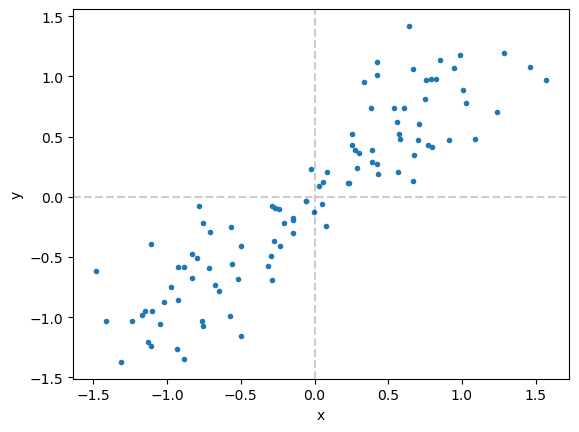

PyObject <matplotlib.lines.Line2D object at 0x7f9e781ddc90>

In [23]:
plot(x,y, ".")
xlabel("x")
ylabel("y")
axhline(0, linestyle="--", color="k", alpha=0.2)
axvline(0, linestyle="--", color="k", alpha=0.2)

The correlation matrix is:

In [24]:
A = [x.-mean(x) y.-mean(y)] # columns are x and y with means subtracted

100×2 Matrix{Float64}:
  0.124222   -0.219352
  0.0227809   0.249823
  0.315317    0.40813
  0.61338     0.229378
  0.433094    0.408413
  0.468822    0.295106
  0.74303     0.489606
  0.799446    0.989201
  0.896713    1.1552
  1.61708     0.988133
  1.05142     0.907034
  1.32902     1.21532
  1.28214     0.725336
  ⋮          
 -1.05845    -0.923803
 -1.06265    -1.22041
 -0.841951   -1.32533
 -0.885835   -1.24612
 -0.880041   -0.564796
 -0.742061   -0.0509618
 -0.516617   -0.534554
 -0.525201   -0.2277
 -0.755918   -0.486642
 -0.194772   -0.0799946
 -0.0997921  -0.281965
  0.0947852  -0.0374883

In [25]:
S = A' * A / (length(x)-1)

2×2 Matrix{Float64}:
 0.560422  0.491678
 0.491678  0.522814

In this case, since there are only two datasets, $S$ is just a $2 \times 2$ matrix.

# Principal Components Analysis and the SVD

A key question in analyizing data analysis is to figure out **which variables are responsible for most of the variation in the data**.    These may not be the variables you measured, but may instead be some **linear combination of the measured variables**!

Mathematically, this corresponds to **"diagonalizing" the covariance (or correlation) matrix**.  This process of diagonalizing the covariance matrix is called [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), or **PCA**.

## Using the SVD basis

Suppose that the take the SVD of $A$:

$$
A = U \Sigma V^T
$$

Let's assume that $A$ is a "tall" matrix (lots of samples $m$) with full column rank $r=n$ (the datasets aren't redundant).   Then (for the "thin" SVD) $U$ is an $m \times n$ matrix with orthonormal columns forming a basis for $C(A)$, $\Sigma$ is an $n \times n$ diagonal matrix of the singular values $\sigma_1,\ldots,\sigma_n$, and $V$ is an $n \times n$ unitary matrix with orthonormal columns.

The claim is that $V$ is the **right basis** in which look at the statistics of the different datasets $A$.   $V$ represents an $n \times n$ "rotation" that we can use to make new linear combination of the columns, i.e. we **write each row in the V basis** to form a new $m \times n$ matrix:

$$
B = A V = U \Sigma V^T V = U \Sigma
$$

The covariance of *this* matrix (which is the *same data in a new coordinate system*) is

$$
S_B = \frac{B^T B}{m-1} = \frac{\Sigma^T U^T U \Sigma}{m-1} = \frac{\Sigma^2}{m-1}
$$

Since $\Sigma^T \Sigma = \Sigma^2$ is a **diagonal matrix** of the *squares* $\sigma_k^2$ of the singular values $\sigma_k$, we find:

* In the $V$ basis, the different datasets become *uncorrelated* ($S_B$ is *diagonal*).
* The squares $\sigma_k^2$ of the singular values are the variances of the *uncorrelated components of the data* (the eigenvalues of $S_B$).
* The right singular vectors $V$ tell you *what linear combinations* of the datasets give you *uncorrelated* variables.

Let's try it:

In [26]:
U, σ, V = svd(A / sqrt(length(x)-1))

SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}
U factor:
100×2 Matrix{Float64}:
  0.00618941   0.110215
 -0.0187483   -0.0741125
 -0.050436    -0.0340296
 -0.0594114    0.117395
 -0.0588439    0.00274283
 -0.0536211    0.0507735
 -0.0864845    0.0733496
 -0.124751    -0.0714615
 -0.143058    -0.0950001
 -0.182912     0.184808
 -0.137065     0.0341293
 -0.17797      0.0207631
 -0.141041     0.165431
  ⋮           
  0.138715    -0.0308745
  0.159347     0.0642684
  0.150821     0.167468
  0.148516     0.127972
  0.101397    -0.0917824
  0.0563457   -0.215694
  0.0734399    0.0121358
  0.0530159   -0.0903411
  0.0871993   -0.0783474
  0.0193561   -0.0349498
  0.0264368    0.0604605
 -0.00418104   0.0418593
singular values:
2-element Vector{Float64}:
 1.0166882449559171
 0.22266815661458467
Vt factor:
2×2 Matrix{Float64}:
 -0.720492  -0.693464
  0.693464  -0.720492

In [27]:
σ.^2

2-element Vector{Float64}:
 1.033654987431543
 0.049581107970137206

Conveniently, the convention for the SVD is to sort the singular values in descending order $\sigma_1 \ge \sigma_2 \ge \cdots$.    So, the **first** singular value/vector represents *most* of the variation in the data, and so on.

In [28]:
V

2×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.720492   0.693464
 -0.693464  -0.720492

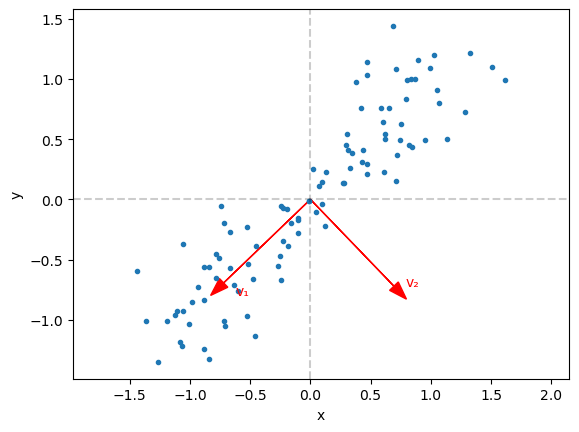

(-1.5937757824796952, 1.7699783509492324, -1.4891141000001884, 1.5795839675613146)

In [29]:
plot(x.-mean(x),y.-mean(y), ".")
xlabel("x")
ylabel("y")
axhline(0, linestyle="--", color="k", alpha=0.2)
axvline(0, linestyle="--", color="k", alpha=0.2)
arrow(0,0, V[:,1]..., head_width=0.1, color="r")
arrow(0,0, V[:,2]..., head_width=0.1, color="r")
text(V[1,1]+0.1,V[2,1]-0.1, "v₁", color="r")
text(V[1,2]+0.1,V[2,2], "v₂", color="r")
axis("equal")

## PCA on the fossil-tooth data

Back to our *Kuehneotherium* example, scientists found that **95.5% of the variation** in the data could be attributed to just the **two largest singular values**.

Therefore, if they **projected** the data onto the corresponding $v_1, v_2$ basis, they now have a **two-dimensional dataset** that contains *almost all* of the original information (equivalently a "rank-2 approximation" of $A$).

Furthermore, plotting the data on these $v_1, v_2$ axes allowed them to not only visualize the data but also to identify **clusters** corresponding to particular species and subgroups.  For reference, the original 9 axes (9 measurements) are shown as red arrows projected onto this plane:

![image](https://i0.wp.com/mathvoices.ams.org/featurecolumn/wp-content/uploads/sites/2/2021/07/cadami.png?w=761&ssl=1)

## More cool PCA applications

* The [eigen-walker](https://www.biomotionlab.ca/Demos/BMLwalker.html) uses PCA to analyze variations in human gaits.
* [eigen-faces](https://en.wikipedia.org/wiki/Eigenface) use PCA to analyze facial variations.

If you google "PCA example" or "principal components analysis" you will find lots of other examples and tutorials.